# HA Fiscal meets HANK and SAM

By William Du (wdu9@jhu.edu)

 This notebook solves a HANK and SAM model where the household block follows the HA-Fiscal households closely.

 This notebook will solve and illustrate the impulse responses to a:

 - UI extension
  - Increase in the replacement rate of UI
  - A cut to the tax rate
  - An increase in transfers (that are proportional to your permanent income)
 - A increase in government spending




In [95]:
# import necessary libraries
import numpy as np
from copy import deepcopy
import scipy.sparse as sp
import matplotlib.pyplot as plt
import time
from HARK.utilities import make_figs

# Calibrate job transition probabilities

In [2]:



job_find = 2/3 # job finding probability
EU_prob = 0.0306834 # EU probability
job_sep = EU_prob/ (1- job_find) # job separation rate


markov_array_ss = np.array([[ 1 - job_sep*(1 - job_find ), job_find, job_find, job_find , job_find , job_find],
       [job_sep*(1-job_find) , 0.        , 0.        , 0 ,  0, 0       ],
       [0.        , (1-job_find), 0.        , 0.  , 0.        , 0.       ],
       [0.        , 0, (1-job_find)        , 0.  , 0.        , 0.       ],
       [0.        , 0, 0.        , (1-job_find)  , 0.        , 0.       ],

       [0.        , 0. , 0 , 0       , (1-job_find), (1-job_find)]  ])

mrkv_temp_for_will =markov_array_ss

num_mrkv = len(markov_array_ss)

eigen, ss_dstn = sp.linalg.eigs(mrkv_temp_for_will , k=1, which='LM') # get steady state distribution over (un)employment states


ss_dstn = ss_dstn[:,0] / np.sum(ss_dstn[:,0]) # Steady state distribution of employed/unemployed 

ss_dstn = ss_dstn.real

U_ss = (1-ss_dstn[0]) # steady state unemployment

N_ss = ss_dstn[0] # steady state employment



# Compute Unemployment Rate Jacobian

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


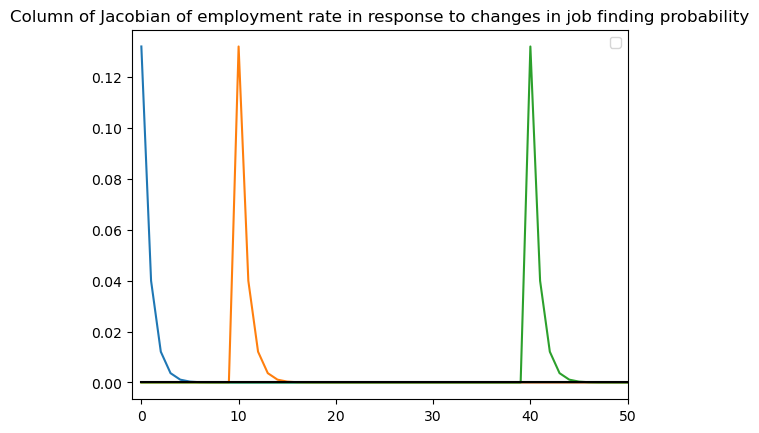

In [3]:
# jacobians for unemployment rate

def create_matrix_U(dx):
    
    job_find_dx = job_find + dx

    markov_array = np.array([[ 1 - job_sep*(1 - job_find_dx ), job_find_dx, job_find_dx, job_find_dx , job_find_dx , job_find_dx],
           [job_sep*(1-job_find_dx) , 0.        , 0.        , 0 ,  0, 0       ],
           [0.        , (1-job_find_dx), 0.        , 0.  , 0.        , 0.       ],
           [0.        , 0, (1-job_find_dx)        , 0.  , 0.        , 0.       ],
           [0.        , 0, 0.        , (1-job_find_dx)  , 0.        , 0.       ],

           [0.        , 0. , 0 , 0       , (1-job_find_dx), (1-job_find_dx)]  ])


    return markov_array

dx = 0.0001


dstn = ss_dstn

bigT = 300
UJAC = np.zeros((num_mrkv,bigT,bigT))

for s in range(bigT):
    for i in range(bigT):
        if i ==s:
            
            tranmat = create_matrix_U(dx)
        
            dstn = np.dot(tranmat,dstn)
    
        else:
            dstn = np.dot(mrkv_temp_for_will,dstn)
    
        UJAC[:,i,s] = (dstn - ss_dstn) / dx

plt.plot(UJAC[0].T[0])
plt.plot(UJAC[0].T[10])
plt.plot(UJAC[0].T[40])
plt.plot(np.zeros(bigT),color ='k')
plt.legend()
plt.xlim(-1,50)
plt.title('Column of Jacobian of employment rate in response to changes in job finding probability')
plt.show()

# Calibration for General equilibrium parameters

In [4]:
# Calibrating General Equilibrium parameters

# elasticity
alpha = .65

# vacancy filling probability
phi_ss = .71 

#vacancies
v_ss = N_ss*job_sep / phi_ss


unemployed_searchers = (ss_dstn[1] + ss_dstn[2] + ss_dstn[3]+ ss_dstn[4]+ ss_dstn[5]) 

# typical job searcher mass is below,
seachers = unemployed_searchers + N_ss*job_sep

# labor market tightness
theta_ss = v_ss/seachers

# matching efficiency
chi_ss = (phi_ss**(1/-alpha) /theta_ss)**(-alpha)

# job finding probabilty economy wide
eta_ss  = chi_ss * theta_ss**(1-alpha) 


R = 1.01 # real interest rate
r_ss = R - 1

C_ss_sim  =0.6910496136078721
C_ss = C_ss_sim

A_ss_sim = 1.4324029855872642
A_ss = A_ss_sim


delta = ((R**4)*(1-(1/5)) )**(1/4) # or you can do delta = R*(1 -(1/20)), 20 quarters is 5 years

qb_ss = (1) / (R - delta) # real price of bonds


B_ss = A_ss/qb_ss # steady state level of bonds

wage_ss = 1.0 # steady state wage (normalized to one)


#before_tax_mean_income = np.mean(IncShkDstn_emp.atoms[1]) / (1-tau_ss)


inc_ui_exhaust = 0.5

tau_ss = 0.3 # steady state tax rate
UI = (1-tau_ss)*.5*wage_ss # Unemployment insurance

# private/passive spousal income
Y_priv = inc_ui_exhaust*(1-tau_ss)*wage_ss*( ss_dstn[3] + ss_dstn[4]  +  ss_dstn[5]  ) + (.7-.5)*(1-tau_ss)*wage_ss*(ss_dstn[1] + ss_dstn[2] ) #+ wage_ss*(1-tau_ss)*(inc_ui_exhaust -  0.13)*( mean_human_capital_u[3] +mean_human_capital_u[6]+mean_human_capital_u[7])

G_ss = tau_ss*wage_ss*ss_dstn[0] - ( UI*(ss_dstn[1] + ss_dstn[2]  )    + ( 1 + delta*qb_ss)*B_ss - qb_ss*B_ss )   # steady state government spending


kappa = .07*(wage_ss*phi_ss) 
HC_ss =  ( ( kappa/phi_ss) * ( 1 - (1/R)*(1-job_sep) )  + wage_ss ) # Steady State hiring cost 



epsilon_p = 6 # elasticity of substitution


MC_ss = (epsilon_p - 1) /epsilon_p # steady state marginal cost
 
Z_ss = HC_ss/MC_ss # TFP

Y_ss = Z_ss*N_ss # output


#Steady state inflation
pi_ss = 0.0 

#Policy
phi_pi = 1.5 # taylor rule coefficient on inflation
phi_y = 0.0 # taylor rule coefficient on output


varphi = 96.9 # price adjustment cost


rho_r = 0.0 # inertia of taylor rule
kappa_p_ss = epsilon_p/varphi # slope of Phillips curve

print('slope of phillips curve', kappa_p_ss)

phi_b = .1 # Speed of fiscal adjustment




slope of phillips curve 0.06191950464396284


# Specify General Equilibrium Blocks

In [5]:

import sequence_jacobian as sj

from sequence_jacobian.classes import JacobianDict, SteadyStateDict
from sequence_jacobian import het, simple, create_model              # functions
from sequence_jacobian.blocks.block import Block
from sequence_jacobian.classes.result_dict import ResultDict
import sequence_jacobian as sj  # SSJ will allow us to define blocks, models, compute IRFs, etc
from matplotlib.pyplot import figure

@sj.simple
def unemployment1(U1,U2,U3, U4, U5) :
    
    U = U1 + U2 + U3 + U4 + U5
    
    return U

@sj.simple
def marginal_cost(HC,Z):
    
    MC =  HC/Z
    return MC


@sj.solved(unknowns={'HC': (-10, 10.0)}, targets=['HC_resid'], solver="brentq")
def hiring_cost(HC,Z,phi,job_sep,r_ante,w):
    
    
    HC_resid = HC - (  ( w  + (kappa/(phi)) - (1/ (1 + r_ante ) )*(1-job_sep) *( kappa/( phi(+1))     )))

    return HC_resid



phi_w = 1.0

@sj.solved(unknowns={'w': (-10, 10.0)}, targets=['wage_resid'], solver="brentq")
def wage_(w,N,phi_w):
    
    wage_resid =( w/wage_ss).apply(np.log) - ( phi_w* (w(-1)/wage_ss).apply(np.log) +  (1 - phi_w)*(N/N_ss).apply(np.log)  )
    return wage_resid






@sj.solved(unknowns={'pi': (-0.1, 0.1)}, targets=['nkpc_resid'], solver="brentq")
def Phillips_Curve(pi,MC,Y,r_ante,epsilon_p,kappa_p):

    nkpc_resid =  (1+pi).apply(np.log) - (  kappa_p*(MC-MC_ss) +  (1/ (1 + r_ante ) ) *(Y(+1)/Y) * (1 + pi(+1) ).apply(np.log) )

    return nkpc_resid



@sj.solved(unknowns={'i': (-.5, 0.4)}, targets=['taylor_resid'], solver="brentq")
def taylor(i,pi,Y,ev,rho_r,phi_y,phi_pi):
    taylor_resid = i - rho_r*i(-1) - (1-rho_r)*( phi_pi*pi + phi_y*Y ) - ev
    return taylor_resid


@sj.solved(unknowns={'i': (-.5, 0.4)}, targets=['taylor_resid'], solver="brentq")
def taylor_lagged(i,pi,Y,ev,rho_r,phi_y,phi_pi,lag):
    taylor_resid = i - rho_r*i(-1) - (1-rho_r)*( phi_pi*pi(-lag) + phi_y*Y(-lag)) - ev
                                                
    return taylor_resid



@sj.simple
def matching(theta,chi):
    
    eta  = chi * theta**(1-alpha)
    
    phi = chi * theta**(-alpha)

    
    
    return eta,phi
    



@sj.solved(unknowns={'B': (0.0, 10)}, targets=['fiscal_resid'], solver="brentq")
def fiscal(B,N,qb,G,  w,v,pi,phi_b, UI, U1, U2, U3 , U4, transfers,UI_extend, deficit_T,UI_rr):
    
    
    
    fiscal_resid = (1 + delta*qb)*B(-1) + G + transfers +  UI *(U1 + U2  )  + UI_rr*wage_ss*(1-tau_ss)*(U1 + U2  ) + UI_extend*wage_ss*(1-tau_ss)*(U3 + U4)  +  - qb*B - (tau_ss +phi_b*qb_ss*(B(deficit_T)-B_ss)/Y_ss)*w*N

    #UI_extension_cost = UI_extend*(U3 + U4)

    UI_extension_cost  =UI_extend*wage_ss*(1-tau_ss)*(U3 + U4)

    UI_rr_cost =   UI_rr*wage_ss*(1-tau_ss)*(U1 + U2  )

    debt = qb*B

    return fiscal_resid,UI_extension_cost,debt,UI_rr_cost






@sj.simple
def fiscal_rule(B,phi_b,deficit_T):
    
    tau = tau_ss + phi_b*qb_ss*(B(deficit_T)-B_ss)/Y_ss
    
    return tau



@sj.solved(unknowns={'B': (0.0, 10)}, targets=['fiscal_resid'], solver="brentq")
def fiscal_G(B,N,qb,  w,v,pi, UI, U1, U2, transfers, phi_G,tau,deficit_T):
    
    fiscal_resid = (1 + delta*qb)*B(-1) + G_ss + phi_G*qb_ss*(B(deficit_T)-B_ss)/Y_ss + transfers +  UI *(U1 + U2  )  +  - qb*B - (tau)*w*N

    tax_cost = (tau)*1.0*N_ss

    #tax_cost = (tau)*w*N


    return fiscal_resid,tax_cost



@sj.simple
def fiscal_rule_G(B,phi_G,deficit_T):
    
    G = G_ss + phi_G*qb_ss*(B(deficit_T)-B_ss)/Y_ss
    
    return G



@sj.simple
def production(Z,N):
    Y  = Z*N
    return Y


@sj.simple
def ex_post_longbonds_rate(qb):
    
    r = (1 + delta * qb)/qb(-1) - 1

    return r


@sj.solved(unknowns={'qb': (0.1, 30.0)}, targets=['lbp_resid'], solver="brentq")
def longbonds_price(qb, r_ante):
    lbp_resid = qb - (1 + delta * qb(+1) )/ (1 + r_ante)
    return lbp_resid

@sj.simple
def vacancies(N,phi,job_sep):
    
    v = (N - (1-job_sep(-1))*N(-1))/phi
    
    return v


@sj.simple
def mkt_clearing( C ,G,A,qb,B,w,N,U1,U2,U3, U4, U5):
    

    Y_priv = (1-tau_ss)*wage_ss*.5*  (U3 + U4 + U5)  + (1-tau_ss)*wage_ss*.2*(U1 + U2)

    goods_mkt = C + G - w*N  - Y_priv 
    
    asset_mkt = A  - qb*B

    return goods_mkt, asset_mkt,Y_priv



@sj.simple
def fisher_clearing(r_ante,pi,i):
    
    fisher_resid = 1 + r_ante - ((1+i)/(1+pi(+1))) 
    
    return fisher_resid




In [6]:





@sj.simple
def fisher_clearing_fixed_real_rate(pi):
    """
    fisher_resid = 1 + r_ss - ((1+i)/(1+pi(+1))) 
    """
    i = ( 1 + pi(+1) ) * (1 + r_ss ) - 1
    return i

@sj.solved(unknowns={'B': (0.0, 10)}, targets=['fiscal_resid'], solver="brentq")
def fiscal_fixed_real_rate(B,N,G,  w,v,pi,phi_b, UI, U1, U2, U3 , U4, transfers,UI_extend, deficit_T,UI_rr):
    
    fiscal_resid = (1 + delta*qb_ss)*B(-1) + G + transfers +  UI *(U1 + U2  )  + UI_rr*wage_ss*(1-tau_ss)*(U1 + U2  ) + UI_extend*wage_ss*(1-tau_ss)*(U3 + U4)  +  - qb_ss*B - (tau_ss +phi_b*qb_ss*(B(deficit_T)-B_ss)/Y_ss)*w*N


    #UI_extension_cost = UI_extend*(U3 + U4)

    UI_extension_cost  = UI_extend*wage_ss*(1-tau_ss)*(U3 + U4)

    UI_rr_cost =   UI_rr*wage_ss*(1-tau_ss)*(U1 + U2  )


    return fiscal_resid,UI_extension_cost,UI_rr_cost


@sj.solved(unknowns={'B': (0.0, 10)}, targets=['fiscal_resid'], solver="brentq")
def fiscal_G_fixed_real_rate(B,N,  w,v,pi, UI, U1, U2, transfers, phi_G,tau,deficit_T):
    
    fiscal_resid = (1 + delta*qb_ss)*B(-1) + G_ss + phi_G*qb_ss*(B(deficit_T)-B_ss)/Y_ss + transfers +  UI *(U1 + U2  )  +  - qb_ss*B - (tau)*w*N
    tax_cost = (tau)*1.0*N_ss

    #tax_cost = (tau)*w*N



    return fiscal_resid,tax_cost


# Define steady state dictionary

In [7]:

# define steady state dictionary

SteadyState_Dict = SteadyStateDict({ "asset_mkt":0.0,
                                         "goods_mkt":0.0,
                                    "arg_fisher_resid":0.0,
                                    "lbp_resid": 0.0,
                                    "fiscal_resid":0.0,
                                    "labor_evo_resid": 0.0,
                                    "taylor_resid": 0.0,
                                    "nkpc_resid": 0.0,
                                    
                                    "epsilon_p": epsilon_p,
                                    "U": (1-N_ss),
                                    "U1": ss_dstn[1],
                                    "U2": ss_dstn[2],
                                    "U3": ss_dstn[3],
                                    "U4": ss_dstn[4],
                                    "U5": ss_dstn[5],

                                    "HC": MC_ss*Z_ss,
                        
                                    "MC": MC_ss,
                                    "C": C_ss_sim,
                                    "r": r_ss, 
                                    "r_ante": r_ss,
                                    "Y": Y_ss,
                                    "B":B_ss, 
                                    "G":G_ss, 
                                    "A": A_ss_sim, 
                                    "tau": tau_ss,
                                    "eta": eta_ss,
                                    "phi_b": phi_b,
                                    "phi_w":phi_w,

                                    
                                    "N": N_ss,
                                    
                                    "phi": phi_ss,
                                    "v": v_ss,
                                    "ev": 0.0,
                                    "Z": Z_ss,
                                    "job_sep": job_sep,
                                    "w":wage_ss,
                                    "pi":pi_ss,
                                    "i": r_ss,
                                    "qb": qb_ss,
          
            
                                    "varphi":varphi,
                                    "rho_r": rho_r,
                                    "kappa_p":kappa_p_ss,
                                    "phi_pi": phi_pi,
                                    "phi_y": phi_y,
                                    
                                    "chi": chi_ss,
                                    "theta": theta_ss,
                                    "UI" : UI,
                                    "transfers": 0.0,
                                    "UI_extend": 0.0,
                                    "deficit_T": -1,
                                    "UI_extension_cost" : 0.0,
                                    "UI_rr": 0.0,
                                    "debt": qb_ss*B_ss,
                                    "tax_cost": tau_ss*wage_ss*N_ss,

                                    "lag": -1
                       
                             })



# Import pre-computed Jacobians from pickle files

In [8]:

import pickle # Import Jacobians


obj = open('HA_Fiscal_Jacs.obj', 'rb')
HA_fiscal_JAC = pickle.load(obj)
obj.close()

# main jacobians for aggregate consumption and aggregate assets
Jacobian_Dict = JacobianDict( { 'C' : HA_fiscal_JAC['C'] ,
                                    
                                  'A' : HA_fiscal_JAC['A'] } )

CJACs_by_educ = HA_fiscal_JAC['C_by_educ']
AJACs_by_educ = HA_fiscal_JAC['A_by_educ']



obj = open('HA_Fiscal_Jacs_UI_extend_real.obj', 'rb')
UI_extend_realized_Jacs= pickle.load(obj)
obj.close()


Jacobian_Dict_UI_extend_real = deepcopy(JacobianDict( { 'C' : HA_fiscal_JAC['C'] ,
                                    
                                  'A' : HA_fiscal_JAC['A'] } ))

Jacobian_Dict_UI_extend_real['C']['UI_extend'] = UI_extend_realized_Jacs['C']['UI_extend_real']
Jacobian_Dict_UI_extend_real['A']['UI_extend'] = UI_extend_realized_Jacs['A']['UI_extend_real']



Jacobian_Dict_by_educ = JacobianDict( { 'C_dropout' :CJACs_by_educ['dropout'] ,
                               'C_highschool':CJACs_by_educ['highschool'] ,
                               'C_college' :CJACs_by_educ['college'],
                                    
                                  'A_dropout' : AJACs_by_educ['dropout'] ,
                               'A_highschool' : AJACs_by_educ['highschool'] ,
                               'A_college' : AJACs_by_educ['college']  } )


# (Un)employment rate Jacobians
UJAC_dict = JacobianDict( {    'N': {'eta': UJAC[0]},

    'U1': {'eta': UJAC[1]},
    'U2': {'eta': UJAC[2]},
    'U3': {'eta': UJAC[3]},
    'U4': {'eta': UJAC[4]},
    'U5': {'eta': UJAC[5]},})


    

In [9]:
from copy import copy
old_Jacobian_Dict = deepcopy(Jacobian_Dict)
periods = old_Jacobian_Dict['C']['transfers'].shape[0]

do_splurge = True
if do_splurge:
    splurge = 0.3
    # Loop though Jacobians
    for jacobian_input in ['transfers', 'tau', 'UI_extend', 'UI_rr' , 'eta', 'w']:
        # Calculate the present value of the policy announced for time s
        present_value = np.sum((old_Jacobian_Dict['C'][jacobian_input]/R**np.arange(periods)),axis=0)
        # The splurge jacobian consists of spending the value of the policy at the time that the cash arrives
        splurge_jacobian_component = np.diag(present_value*R**np.arange(periods))
        # The total splurge jacobian is a weighted average of the spurge component and the original jacobian
        splurge_jacobian = splurge*splurge_jacobian_component + (1-splurge)*old_Jacobian_Dict['C'][jacobian_input]
        Jacobian_Dict['C'][jacobian_input] = splurge_jacobian
        Jacobian_Dict['A'][jacobian_input] = (1-splurge)*old_Jacobian_Dict['A'][jacobian_input]
                            
            
                           

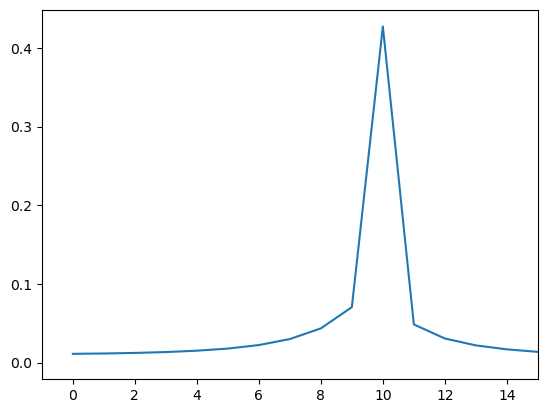

In [10]:
plt.plot(Jacobian_Dict['C']['transfers'].T[10])
plt.xlim(-1,15)
plt.show()

In [11]:
#plt.plot(Jacobian_Dict['C']['tau'].T[10])
#plt.xlim(-1,15)
#plt.show()

# Create HANK and SAM models

In [12]:

HANK_SAM = create_model([Jacobian_Dict, 
                         Jacobian_Dict_by_educ,
                          fiscal,
                          longbonds_price,
                          ex_post_longbonds_rate,
                          fiscal_rule,
                          production,
                          matching,
                          taylor,
                          Phillips_Curve,
                          marginal_cost,
                          UJAC_dict,
                          hiring_cost,
                          wage_,
                          vacancies,
                          
                          unemployment1,

                          fisher_clearing,mkt_clearing], name="HARK_HANK")




HANK_SAM_tax_rate_shock = create_model([Jacobian_Dict, 
                                        Jacobian_Dict_by_educ,
                          fiscal_G,
                          
                          longbonds_price,
                          ex_post_longbonds_rate,
                          fiscal_rule_G,
                          
                          production,
                          matching,
                          taylor,
                          Phillips_Curve,
                          marginal_cost,
                          UJAC_dict,
                    
                          hiring_cost,
                          wage_,
                          vacancies,
                          
                          unemployment1,
                          fisher_clearing,mkt_clearing], name="HARK_HANK")

HANK_SAM_lagged_taylor_rule = create_model([Jacobian_Dict, 
                         Jacobian_Dict_by_educ,
                          fiscal,
                          longbonds_price,
                          ex_post_longbonds_rate,
                          fiscal_rule,
                          production,
                          matching,
                          taylor_lagged,
                          Phillips_Curve,
                          marginal_cost,
                          UJAC_dict,
                          hiring_cost,
                          wage_,
                          vacancies,
                          
                          unemployment1,

                          fisher_clearing,
                          mkt_clearing], name="HARK_HANK")


HANK_SAM_fixed_real_rate = create_model([Jacobian_Dict, 
                         Jacobian_Dict_by_educ,
                          fiscal_fixed_real_rate,
                          #longbonds_price,
                          #ex_post_longbonds_rate,
                          fiscal_rule,
                          production,
                          matching,
                          #taylor_lagged,
                          Phillips_Curve,
                          marginal_cost,
                          UJAC_dict,
                          hiring_cost,
                          wage_,
                          vacancies,
                          
                          unemployment1,

                          fisher_clearing_fixed_real_rate,
                          mkt_clearing], name="HARK_HANK")

HANK_SAM_fixed_real_rate_UI_extend_real = create_model([Jacobian_Dict_UI_extend_real, 
                         Jacobian_Dict_by_educ,
                          fiscal_fixed_real_rate,
                          #longbonds_price,
                          #ex_post_longbonds_rate,
                          fiscal_rule,
                          production,
                          matching,
                          #taylor_lagged,
                          Phillips_Curve,
                          marginal_cost,
                          UJAC_dict,
                          hiring_cost,
                          wage_,
                          vacancies,
                          
                          unemployment1,

                          fisher_clearing_fixed_real_rate,
                          mkt_clearing], name="HARK_HANK")



HANK_SAM_tax_cut_fixed_real_rate = create_model([Jacobian_Dict, 
                         Jacobian_Dict_by_educ,
                          fiscal_G_fixed_real_rate,
                          #longbonds_price,
                          #ex_post_longbonds_rate,
                          fiscal_rule_G,
                          production,
                          matching,
                          #taylor_lagged,
                          Phillips_Curve,
                          marginal_cost,
                          UJAC_dict,
                          hiring_cost,
                          wage_,
                          vacancies,
                          
                          unemployment1,

                          fisher_clearing_fixed_real_rate,
                          mkt_clearing], name="HARK_HANK")







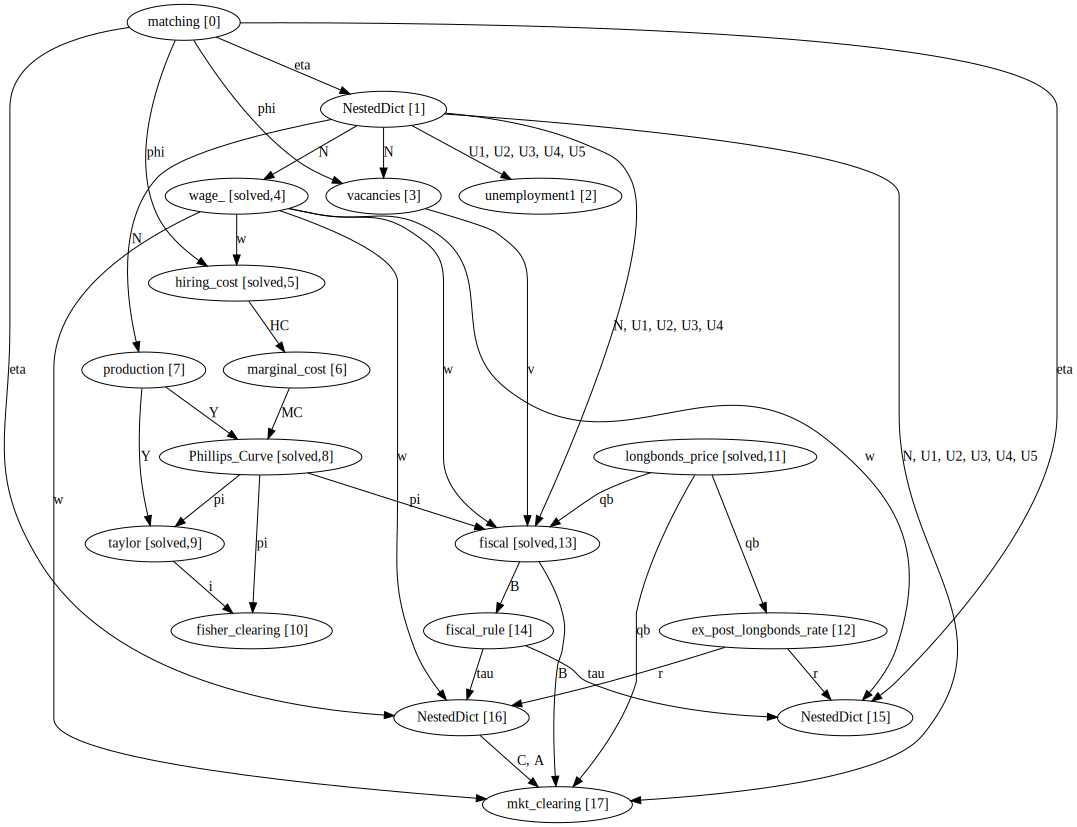

In [13]:
sj.drawdag(HANK_SAM)

# Impulse response analysis

In [14]:

# This function will helps plot irfs
def plot_irfs(irf_b1,irf_b2, label_b1 , label_b2 ):
    
    green = 'darkorange'
    benchmark =  label_b1
    fixed_rate = label_b2
    Length = 40
    fontsize = 10
    width = 2
    label_size = 8
    legend_size = 8
    ticksize = 8
    fig, axs = plt.subplots(3, 2, figsize=(7,8))
    axs[0, 0].plot(10000*irf_b1['i'][:Length],linewidth= width,label = benchmark )
    axs[0, 0].plot(10000*irf_b2['i'][:Length],linewidth= width, label = fixed_rate , linestyle = '--', color = green)
    axs[0, 0].plot(np.zeros(Length),'k' )
    axs[0, 0].legend(prop={'size': legend_size})
    axs[0, 0].set_ylabel('Basis points (quarterly)', fontsize = label_size)
    axs[0, 0].set_xlabel('Quarters', fontsize = label_size)

    axs[0, 0].set_title("Nominal Interest Rate",fontdict={'fontsize': fontsize})
    axs[0, 0].tick_params(axis='both', labelsize=ticksize)
    axs[0, 0].locator_params(axis='both', nbins=5) 
    axs[1, 0].plot(100*irf_b1['Y'][:Length]/Y_ss,linewidth= width, label = benchmark )
    axs[1, 0].plot(100*irf_b2['Y'][:Length]/Y_ss,linewidth= width,label = fixed_rate, linestyle = '--' , color = green)
    axs[1, 0].plot(np.zeros(Length),'k' )
    axs[1, 0].set_ylabel('% Deviation', fontsize = label_size)
    axs[1, 0].set_title("Output",fontdict={'fontsize': fontsize})
    axs[1, 0].sharex(axs[0, 0])
    axs[1, 0].tick_params(axis='both', labelsize=ticksize)
    axs[1, 0].set_xlabel('Quarters', fontsize = label_size)
    axs[1, 0].locator_params(axis='both', nbins=5) 
    axs[0, 1].plot(100*irf_b1['U'][:Length],linewidth= width, label = benchmark)
    axs[0, 1].plot(100*irf_b2['U'][:Length],linewidth= width, label = fixed_rate, linestyle = '--', color = green)
    axs[0, 1].plot(np.zeros(Length),'k' )
    axs[0, 1].set_ylabel('% points', fontsize = label_size)
    axs[0, 1].set_xlabel('Quarters', fontsize = label_size)

    axs[0, 1].set_title("Unemployment Rate",fontdict={'fontsize': fontsize})
    axs[0, 1].tick_params(axis='both', labelsize=ticksize)
    axs[0, 1].locator_params(axis='both', nbins=4) 
    axs[1, 1].plot(100*irf_b1['pi'][:Length],linewidth= width, label = benchmark)
    axs[1, 1].plot(100*irf_b2['pi'][:Length],linewidth= width, label = fixed_rate, linestyle = '--', color = green)
    axs[1, 1].plot(np.zeros(Length),'k' )
    axs[1, 1].tick_params(axis='both', labelsize=ticksize)
    axs[1, 1].set_title("inflation",fontdict={'fontsize': fontsize})
    axs[1, 1].set_ylabel('% points', fontsize = label_size)
    axs[1, 1].set_xlabel('Quarters', fontsize = label_size)
    axs[1, 1].locator_params(axis='both', nbins=4) 
    axs[2, 1].plot(100*irf_b1['C'][:Length]/C_ss,linewidth= width, label = benchmark)
    axs[2, 1].plot(100*irf_b2['C'][:Length]/C_ss,linewidth= width, label = fixed_rate, linestyle = '--', color = green)
    axs[2, 1].plot(np.zeros(Length),'k' )
    axs[2, 1].tick_params(axis='both', labelsize=ticksize)
    axs[2, 1].set_title("Consumption",fontdict={'fontsize': fontsize})
    axs[2, 1].set_ylabel('% deviation', fontsize = label_size)
    axs[2, 1].set_xlabel('Quarters', fontsize = label_size)
    axs[2, 1].locator_params(axis='both', nbins=4) 
    axs[2, 0].plot(10000*irf_b1['r_ante'][:Length],linewidth= width, label = benchmark)
    axs[2, 0].plot(10000*irf_b2['r_ante'][:Length],linewidth= width, label = fixed_rate, linestyle = '--', color = green)
    axs[2, 0].plot(np.zeros(Length),'k' )
    axs[2, 0].tick_params(axis='both', labelsize=ticksize)
    axs[2, 0].set_title("real interest rate",fontdict={'fontsize': fontsize})
    axs[2, 0].set_ylabel('basis points (quarterly)', fontsize = label_size)
    axs[2, 0].set_xlabel('Quarters', fontsize = label_size)
    axs[2, 0].locator_params(axis='both', nbins=4) 
    fig.tight_layout()


In [15]:

# This function will helps plot irfs
def plot_irfs_fixed_real_rate(irf_b1,irf_b2, label_b1 , label_b2 ):
    
    green = 'darkorange'
    benchmark =  label_b1
    fixed_rate = label_b2
    Length = 40
    fontsize = 10
    width = 2
    label_size = 8
    legend_size = 8
    ticksize = 8
    fig, axs = plt.subplots(3, 2, figsize=(7,8))
    axs[0, 0].plot(10000*irf_b1['i'][:Length],linewidth= width,label = benchmark )
    axs[0, 0].plot(10000*irf_b2['i'][:Length],linewidth= width, label = fixed_rate , linestyle = '--', color = green)
    axs[0, 0].plot(np.zeros(Length),'k' )
    axs[0, 0].legend(prop={'size': legend_size})
    axs[0, 0].set_ylabel('Basis points (quarterly)', fontsize = label_size)
    axs[0, 0].set_xlabel('Quarters', fontsize = label_size)

    axs[0, 0].set_title("Nominal Interest Rate",fontdict={'fontsize': fontsize})
    axs[0, 0].tick_params(axis='both', labelsize=ticksize)
    axs[0, 0].locator_params(axis='both', nbins=5) 
    axs[1, 0].plot(100*irf_b1['Y'][:Length]/Y_ss,linewidth= width, label = benchmark )
    axs[1, 0].plot(100*irf_b2['Y'][:Length]/Y_ss,linewidth= width,label = fixed_rate, linestyle = '--' , color = green)
    axs[1, 0].plot(np.zeros(Length),'k' )
    axs[1, 0].set_ylabel('% Deviation', fontsize = label_size)
    axs[1, 0].set_title("Output",fontdict={'fontsize': fontsize})
    axs[1, 0].sharex(axs[0, 0])
    axs[1, 0].tick_params(axis='both', labelsize=ticksize)
    axs[1, 0].set_xlabel('Quarters', fontsize = label_size)
    axs[1, 0].locator_params(axis='both', nbins=5) 
    axs[0, 1].plot(100*irf_b1['U'][:Length],linewidth= width, label = benchmark)
    axs[0, 1].plot(100*irf_b2['U'][:Length],linewidth= width, label = fixed_rate, linestyle = '--', color = green)
    axs[0, 1].plot(np.zeros(Length),'k' )
    axs[0, 1].set_ylabel('% points', fontsize = label_size)
    axs[0, 1].set_xlabel('Quarters', fontsize = label_size)

    axs[0, 1].set_title("Unemployment Rate",fontdict={'fontsize': fontsize})
    axs[0, 1].tick_params(axis='both', labelsize=ticksize)
    axs[0, 1].locator_params(axis='both', nbins=4) 
    axs[1, 1].plot(100*irf_b1['pi'][:Length],linewidth= width, label = benchmark)
    axs[1, 1].plot(100*irf_b2['pi'][:Length],linewidth= width, label = fixed_rate, linestyle = '--', color = green)
    axs[1, 1].plot(np.zeros(Length),'k' )
    axs[1, 1].tick_params(axis='both', labelsize=ticksize)
    axs[1, 1].set_title("inflation",fontdict={'fontsize': fontsize})
    axs[1, 1].set_ylabel('% points', fontsize = label_size)
    axs[1, 1].set_xlabel('Quarters', fontsize = label_size)
    axs[1, 1].locator_params(axis='both', nbins=4) 
    axs[2, 1].plot(100*irf_b1['C'][:Length]/C_ss,linewidth= width, label = benchmark)
    axs[2, 1].plot(100*irf_b2['C'][:Length]/C_ss,linewidth= width, label = fixed_rate, linestyle = '--', color = green)
    axs[2, 1].plot(np.zeros(Length),'k' )
    axs[2, 1].tick_params(axis='both', labelsize=ticksize)
    axs[2, 1].set_title("Consumption",fontdict={'fontsize': fontsize})
    axs[2, 1].set_ylabel('% deviation', fontsize = label_size)
    axs[2, 1].set_xlabel('Quarters', fontsize = label_size)
    axs[2, 1].locator_params(axis='both', nbins=4) 
    axs[2, 0].plot(10000*irf_b1['r_ante'][:Length],linewidth= width, label = benchmark)
    axs[2, 0].plot(np.zeros(Length),linewidth= width, label = fixed_rate, linestyle = '--', color = green)
    axs[2, 0].plot(np.zeros(Length),'k' )
    axs[2, 0].tick_params(axis='both', labelsize=ticksize)
    axs[2, 0].set_title("real interest rate",fontdict={'fontsize': fontsize})
    axs[2, 0].set_ylabel('basis points (quarterly)', fontsize = label_size)
    axs[2, 0].set_xlabel('Quarters', fontsize = label_size)
    axs[2, 0].locator_params(axis='both', nbins=4) 
    fig.tight_layout()


In [16]:
def plot_irfs_three(irf_b1,irf_b2,irf_b3, label_b1 , label_b2,label_b3 ):
    
    green = 'darkorange'
    red = 'red'
    benchmark =  label_b1
    fixed_rate = label_b2
    lagged_taylor_rule = label_b3

    Length = 40
    fontsize = 10
    width = 2
    label_size = 8
    legend_size = 8
    ticksize = 8
    fig, axs = plt.subplots(3, 2, figsize=(7,8))
    axs[0, 0].plot(10000*irf_b1['i'][:Length],linewidth= width,label = benchmark )
    axs[0, 0].plot(10000*irf_b2['i'][:Length],linewidth= width, label = fixed_rate , linestyle = '--', color = green)
    axs[0, 0].plot(10000*irf_b3['i'][:Length],linewidth= width, label = lagged_taylor_rule , linestyle = '--', color = red)

    axs[0, 0].plot(np.zeros(Length),'k' )
    axs[0, 0].legend(prop={'size': legend_size})
    axs[0, 0].set_ylabel('Basis points (quarterly)', fontsize = label_size)
    axs[0, 0].set_xlabel('Quarters', fontsize = label_size)

    axs[0, 0].set_title("Nominal Interest Rate",fontdict={'fontsize': fontsize})
    axs[0, 0].tick_params(axis='both', labelsize=ticksize)
    axs[0, 0].locator_params(axis='both', nbins=5) 
    axs[1, 0].plot(100*irf_b1['Y'][:Length]/Y_ss,linewidth= width, label = benchmark )
    axs[1, 0].plot(100*irf_b2['Y'][:Length]/Y_ss,linewidth= width,label = fixed_rate, linestyle = '--' , color = green)
    axs[1, 0].plot(100*irf_b3['Y'][:Length]/Y_ss,linewidth= width, label = lagged_taylor_rule , linestyle = '--', color = red)

    axs[1, 0].plot(np.zeros(Length),'k' )
    axs[1, 0].set_ylabel('% Deviation', fontsize = label_size)
    axs[1, 0].set_title("Output",fontdict={'fontsize': fontsize})
    axs[1, 0].sharex(axs[0, 0])
    axs[1, 0].tick_params(axis='both', labelsize=ticksize)
    axs[1, 0].set_xlabel('Quarters', fontsize = label_size)
    axs[1, 0].locator_params(axis='both', nbins=5) 
    axs[0, 1].plot(100*irf_b1['U'][:Length],linewidth= width, label = benchmark)
    axs[0, 1].plot(100*irf_b2['U'][:Length],linewidth= width, label = fixed_rate, linestyle = '--', color = green)
    axs[0, 1].plot(100*irf_b3['U'][:Length],linewidth= width, label = lagged_taylor_rule , linestyle = '--', color = red)

    axs[0, 1].plot(np.zeros(Length),'k' )
    axs[0, 1].set_ylabel('% points', fontsize = label_size)
    axs[0, 1].set_xlabel('Quarters', fontsize = label_size)

    axs[0, 1].set_title("Unemployment Rate",fontdict={'fontsize': fontsize})
    axs[0, 1].tick_params(axis='both', labelsize=ticksize)
    axs[0, 1].locator_params(axis='both', nbins=4) 
    axs[1, 1].plot(100*irf_b1['pi'][:Length],linewidth= width, label = benchmark)
    axs[1, 1].plot(100*irf_b2['pi'][:Length],linewidth= width, label = fixed_rate, linestyle = '--', color = green)
    axs[1, 1].plot(100*irf_b3['pi'][:Length],linewidth= width, label = lagged_taylor_rule , linestyle = '--', color = red)

    axs[1, 1].plot(np.zeros(Length),'k' )
    axs[1, 1].tick_params(axis='both', labelsize=ticksize)
    axs[1, 1].set_title("inflation",fontdict={'fontsize': fontsize})
    axs[1, 1].set_ylabel('% points', fontsize = label_size)
    axs[1, 1].set_xlabel('Quarters', fontsize = label_size)
    axs[1, 1].locator_params(axis='both', nbins=4) 
    axs[2, 1].plot(100*irf_b1['C'][:Length]/C_ss,linewidth= width, label = benchmark)
    axs[2, 1].plot(100*irf_b2['C'][:Length]/C_ss,linewidth= width, label = fixed_rate, linestyle = '--', color = green)
    axs[2, 1].plot(100*irf_b3['C'][:Length]/C_ss,linewidth= width, label = lagged_taylor_rule , linestyle = '--', color = red)

    axs[2, 1].plot(np.zeros(Length),'k' )
    axs[2, 1].tick_params(axis='both', labelsize=ticksize)
    axs[2, 1].set_title("Consumption",fontdict={'fontsize': fontsize})
    axs[2, 1].set_ylabel('% deviation', fontsize = label_size)
    axs[2, 1].set_xlabel('Quarters', fontsize = label_size)
    axs[2, 1].locator_params(axis='both', nbins=4) 
    axs[2, 0].plot(10000*irf_b1['r_ante'][:Length],linewidth= width, label = benchmark)
    axs[2, 0].plot(10000*irf_b2['r_ante'][:Length],linewidth= width, label = fixed_rate, linestyle = '--', color = green)
    axs[2, 0].plot(10000*irf_b3['r_ante'][:Length],linewidth= width, label = lagged_taylor_rule , linestyle = '--', color = red)
    axs[2, 0].plot(np.zeros(Length),'k' )
    axs[2, 0].tick_params(axis='both', labelsize=ticksize)
    axs[2, 0].set_title("real interest rate",fontdict={'fontsize': fontsize})
    axs[2, 0].set_ylabel('basis points (quarterly)', fontsize = label_size)
    axs[2, 0].set_xlabel('Quarters', fontsize = label_size)
    axs[2, 0].locator_params(axis='both', nbins=4) 
    fig.tight_layout()

In [17]:
def plot_irfs_three_fixed_real_rate(irf_b1,irf_b2,irf_b3, label_b1 , label_b2,label_b3 ):
    
    green = 'darkorange'
    red = 'red'
    benchmark =  label_b1
    fixed_rate = label_b2
    label_3 = label_b3

    Length = 40
    fontsize = 10
    width = 2
    label_size = 8
    legend_size = 8
    ticksize = 8
    fig, axs = plt.subplots(3, 2, figsize=(7,8))
    axs[0, 0].plot(10000*irf_b1['i'][:Length],linewidth= width,label = benchmark )
    axs[0, 0].plot(10000*irf_b2['i'][:Length],linewidth= width, label = fixed_rate , linestyle = '--', color = green)
    axs[0, 0].plot(10000*irf_b3['i'][:Length],linewidth= width, label = label_3 , linestyle = '--', color = red)

    axs[0, 0].plot(np.zeros(Length),'k' )
    axs[0, 0].legend(prop={'size': legend_size})
    axs[0, 0].set_ylabel('Basis points (quarterly)', fontsize = label_size)
    axs[0, 0].set_xlabel('Quarters', fontsize = label_size)

    axs[0, 0].set_title("Nominal Interest Rate",fontdict={'fontsize': fontsize})
    axs[0, 0].tick_params(axis='both', labelsize=ticksize)
    axs[0, 0].locator_params(axis='both', nbins=5) 
    axs[1, 0].plot(100*irf_b1['Y'][:Length]/Y_ss,linewidth= width, label = benchmark )
    axs[1, 0].plot(100*irf_b2['Y'][:Length]/Y_ss,linewidth= width,label = fixed_rate, linestyle = '--' , color = green)
    axs[1, 0].plot(100*irf_b3['Y'][:Length]/Y_ss,linewidth= width, label = label_3 , linestyle = '--', color = red)

    axs[1, 0].plot(np.zeros(Length),'k' )
    axs[1, 0].set_ylabel('% Deviation', fontsize = label_size)
    axs[1, 0].set_title("Output",fontdict={'fontsize': fontsize})
    axs[1, 0].sharex(axs[0, 0])
    axs[1, 0].tick_params(axis='both', labelsize=ticksize)
    axs[1, 0].set_xlabel('Quarters', fontsize = label_size)
    axs[1, 0].locator_params(axis='both', nbins=5) 
    axs[0, 1].plot(100*irf_b1['U'][:Length],linewidth= width, label = benchmark)
    axs[0, 1].plot(100*irf_b2['U'][:Length],linewidth= width, label = fixed_rate, linestyle = '--', color = green)
    axs[0, 1].plot(100*irf_b3['U'][:Length],linewidth= width, label = label_3 , linestyle = '--', color = red)

    axs[0, 1].plot(np.zeros(Length),'k' )
    axs[0, 1].set_ylabel('% points', fontsize = label_size)
    axs[0, 1].set_xlabel('Quarters', fontsize = label_size)

    axs[0, 1].set_title("Unemployment Rate",fontdict={'fontsize': fontsize})
    axs[0, 1].tick_params(axis='both', labelsize=ticksize)
    axs[0, 1].locator_params(axis='both', nbins=4) 
    axs[1, 1].plot(100*irf_b1['pi'][:Length],linewidth= width, label = benchmark)
    axs[1, 1].plot(100*irf_b2['pi'][:Length],linewidth= width, label = fixed_rate, linestyle = '--', color = green)
    axs[1, 1].plot(100*irf_b3['pi'][:Length],linewidth= width, label = label_3 , linestyle = '--', color = red)

    axs[1, 1].plot(np.zeros(Length),'k' )
    axs[1, 1].tick_params(axis='both', labelsize=ticksize)
    axs[1, 1].set_title("inflation",fontdict={'fontsize': fontsize})
    axs[1, 1].set_ylabel('% points', fontsize = label_size)
    axs[1, 1].set_xlabel('Quarters', fontsize = label_size)
    axs[1, 1].locator_params(axis='both', nbins=4) 
    axs[2, 1].plot(100*irf_b1['C'][:Length]/C_ss,linewidth= width, label = benchmark)
    axs[2, 1].plot(100*irf_b2['C'][:Length]/C_ss,linewidth= width, label = fixed_rate, linestyle = '--', color = green)
    axs[2, 1].plot(100*irf_b3['C'][:Length]/C_ss,linewidth= width, label = label_3 , linestyle = '--', color = red)

    axs[2, 1].plot(np.zeros(Length),'k' )
    axs[2, 1].tick_params(axis='both', labelsize=ticksize)
    axs[2, 1].set_title("Consumption",fontdict={'fontsize': fontsize})
    axs[2, 1].set_ylabel('% deviation', fontsize = label_size)
    axs[2, 1].set_xlabel('Quarters', fontsize = label_size)
    axs[2, 1].locator_params(axis='both', nbins=4) 
    axs[2, 0].plot(10000*irf_b1['r_ante'][:Length],linewidth= width, label = benchmark)
    axs[2, 0].plot(10000*irf_b2['r_ante'][:Length],linewidth= width, label = fixed_rate, linestyle = '--', color = green)
    axs[2, 0].plot(np.zeros(Length),linewidth= width, label = label_3, linestyle = '--', color = red)
    axs[2, 0].plot(np.zeros(Length),'k' )
    axs[2, 0].tick_params(axis='both', labelsize=ticksize)
    axs[2, 0].set_title("real interest rate",fontdict={'fontsize': fontsize})
    axs[2, 0].set_ylabel('basis points (quarterly)', fontsize = label_size)
    axs[2, 0].set_xlabel('Quarters', fontsize = label_size)
    axs[2, 0].locator_params(axis='both', nbins=4) 
    fig.tight_layout()

# Different stimulus policies

In [18]:
def NPV(irf,length): # to compute Net present value
    
    NPV = 0
    for i in range(length):
        
        NPV +=irf[i]/R**i
        
        
    return NPV

In [19]:
unknowns = ['theta', 'r_ante' ]
targets = ['asset_mkt', 'fisher_resid' ]
targets_goods_mkt = ['asset_mkt', 'fisher_resid' ]

T = bigT


# UI extensions

In [20]:



#rho_UI_extension  = 0.9
#dUI_extension = (.98*.001/2.1) * rho_UI_extension ** np.arange(T)

dUI_extension = np.zeros(bigT)
dUI_extension[:4] = .2
shocks_UI_extension = {'UI_extend': dUI_extension}


SteadyState_Dict_UI_extend = deepcopy(SteadyState_Dict)

SteadyState_Dict_UI_extend['phi_b'] = 0.015 #fiscal adjustment parameter
SteadyState_Dict_UI_extend['phi_w'] = 0.837 #wage ridigity parameter ( if equal to 1.0 than real wage is fixed)
SteadyState_Dict_UI_extend['rho_r'] = 0.0 #inertial parameter for taylor rule
SteadyState_Dict_UI_extend['phi_y'] = 0.0 #taylor rule coefficient on output
SteadyState_Dict_UI_extend['phi_pi'] = 1.5 #taylor rule coefficient on inflation
SteadyState_Dict_UI_extend['deficit_T'] = -1  #the number of periods it takes for government to adjust and follow its fiscal rule.
#If equal deficit_T = -40, then government will keep taxes fixed for 40 quarters



SteadyState_Dict_UI_extend_fixed_nominal_rate = deepcopy(SteadyState_Dict_UI_extend)
SteadyState_Dict_UI_extend_fixed_nominal_rate['phi_pi'] = 0.0 # taylor rule is not active

irfs_UI_extend = HANK_SAM.solve_impulse_linear(SteadyState_Dict_UI_extend, unknowns, targets, shocks_UI_extension)
irfs_UI_extend_fixed_nominal_rate = HANK_SAM.solve_impulse_linear(SteadyState_Dict_UI_extend_fixed_nominal_rate, unknowns, targets, shocks_UI_extension)





green = 'green'



# Lag in the taylor rule

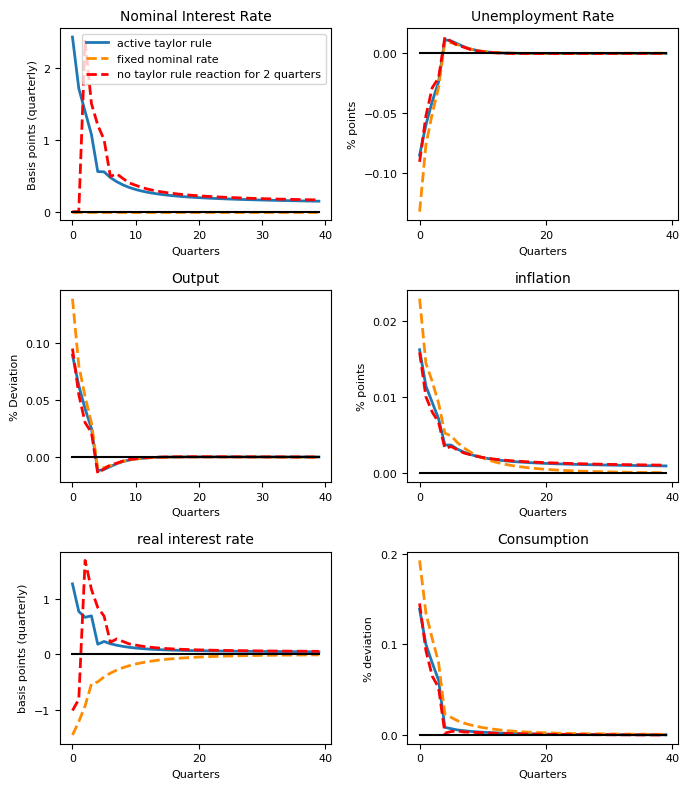

In [21]:
SteadyState_Dict_UI_extend_lagged_nominal_rate = deepcopy(SteadyState_Dict_UI_extend)

monetary_policy_lag = 2 
SteadyState_Dict_UI_extend_lagged_nominal_rate['lag'] = monetary_policy_lag # number of quarters the fed does not react
irfs_UI_extend_lagged_nominal_rate = HANK_SAM_lagged_taylor_rule.solve_impulse_linear(SteadyState_Dict_UI_extend_lagged_nominal_rate, unknowns, targets, shocks_UI_extension)

plot_irfs_three(irfs_UI_extend,irfs_UI_extend_fixed_nominal_rate,irfs_UI_extend_lagged_nominal_rate,'active taylor rule' , 'fixed nominal rate', 'no taylor rule reaction for ' +str(monetary_policy_lag) +' quarters')


## Fixed Real Rate

In [22]:
unknowns_fixed_real_rate = ['theta' ]
targets_fixed_real_rate = ['asset_mkt' ]

In [23]:

irfs_UI_extension_fixed_real_rate = HANK_SAM_fixed_real_rate.solve_impulse_linear(SteadyState_Dict_UI_extend, unknowns_fixed_real_rate, targets_fixed_real_rate, shocks_UI_extension)  # solve for IRFs



# Fixed real rate

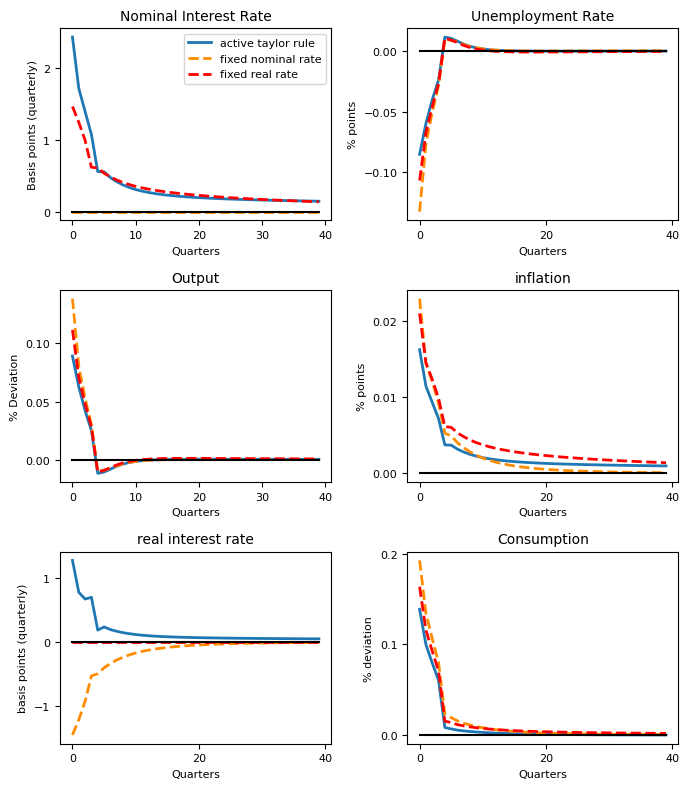

In [24]:
plot_irfs_three_fixed_real_rate(irfs_UI_extend,irfs_UI_extend_fixed_nominal_rate,irfs_UI_extension_fixed_real_rate,'active taylor rule' , 'fixed nominal rate', 'fixed real rate')


In [25]:
print('multiplier out of 2Q UI extension (active taylor rule)', NPV(irfs_UI_extend['Y'], bigT)/NPV(irfs_UI_extend['UI_extension_cost'],bigT))

print('multiplier out of 2Q UI extension (fixed nominal rate)',NPV(irfs_UI_extend_fixed_nominal_rate['Y'], bigT)/NPV(irfs_UI_extend_fixed_nominal_rate['UI_extension_cost'],bigT))
print('multiplier out of 2Q UI extension (fixed real rate)',NPV(irfs_UI_extension_fixed_real_rate['Y'], bigT)/NPV(irfs_UI_extension_fixed_real_rate['UI_extension_cost'],bigT))



multiplier out of 2Q UI extension (active taylor rule) 0.9172245173359743
multiplier out of 2Q UI extension (fixed nominal rate) 1.2707883882933226
multiplier out of 2Q UI extension (fixed real rate) 1.2332325821175891


In [26]:
irf_UI_extend_realizations = HANK_SAM_fixed_real_rate_UI_extend_real.solve_impulse_linear(SteadyState_Dict_UI_extend, unknowns_fixed_real_rate, targets_fixed_real_rate, shocks_UI_extension)  # solve for IRFs

# Transfers


In [27]:



#rho_transfers  = 0.9
#dtransfers = (.98*.001/2.1) * rho_transfers ** np.arange(T)
#shocks_transfers = {'transfers': dtransfers}


dtransfers = np.zeros(bigT)
dtransfers[:1] = C_ss*.05  #Approxiate size of aggregate stimulus check spending 
shocks_transfers = {'transfers': dtransfers}



SteadyState_Dict_transfer = deepcopy(SteadyState_Dict)

SteadyState_Dict_transfer['phi_b'] = 0.015
SteadyState_Dict_transfer['phi_w'] = 0.837
SteadyState_Dict_transfer['rho_r'] = 0.0
SteadyState_Dict_transfer['phi_y'] = 0.0
SteadyState_Dict_transfer['phi_pi'] = 1.5
SteadyState_Dict_transfer['deficit_T'] = -1

SteadyState_Dict_UI_transfer_fixed_nominal_rate = deepcopy(SteadyState_Dict_transfer)
SteadyState_Dict_UI_transfer_fixed_nominal_rate['phi_pi'] = 0.0

irfs_transfer = HANK_SAM.solve_impulse_linear(SteadyState_Dict_transfer, unknowns, targets, shocks_transfers)
irfs_transfer_fixed_nominal_rate = HANK_SAM.solve_impulse_linear(SteadyState_Dict_UI_transfer_fixed_nominal_rate, unknowns, targets, shocks_transfers)





In [28]:
print('multiplier out of transfers', NPV(irfs_transfer['Y'], bigT)/NPV(irfs_transfer['transfers'],bigT))


print('multiplier out of transfers (fixed nominal rate)', NPV(irfs_transfer_fixed_nominal_rate['Y'], bigT)/NPV(irfs_transfer_fixed_nominal_rate['transfers'],bigT))


multiplier out of transfers 0.7997717842782619
multiplier out of transfers (fixed nominal rate) 1.2162615227624092


## lagged taylor rule

Fed does not react for a certain number of periods.

In [29]:
SteadyState_Dict_transfers_lagged_nominal_rate = deepcopy(SteadyState_Dict_transfer)

monetary_policy_lag = 2
SteadyState_Dict_transfers_lagged_nominal_rate['lag'] = monetary_policy_lag # number of quarters the fed does not react
irfs_transfers_lagged_nominal_rate = HANK_SAM_lagged_taylor_rule.solve_impulse_linear(SteadyState_Dict_transfers_lagged_nominal_rate, unknowns, targets, shocks_transfers)

#plot_irfs_three(irfs_transfer,irfs_transfer_fixed_nominal_rate,irfs_transfers_lagged_nominal_rate,'active taylor rule' , 'fixed nominal rate', 'no taylor rule reaction for ' +str(monetary_policy_lag) +' quarters')


## Fixed Real Rate

In [30]:

irfs_transfer_fixed_real_rate = HANK_SAM_fixed_real_rate.solve_impulse_linear(SteadyState_Dict_transfer, unknowns_fixed_real_rate, targets_fixed_real_rate, shocks_transfers)  # solve for IRFs




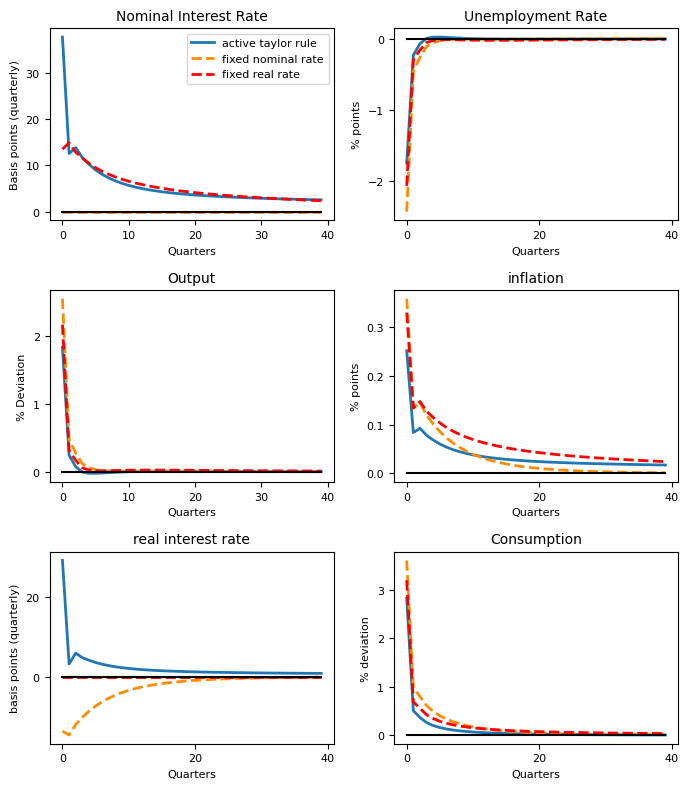

In [31]:
plot_irfs_three_fixed_real_rate(irfs_transfer,irfs_transfer_fixed_nominal_rate,irfs_transfer_fixed_real_rate,'active taylor rule' , 'fixed nominal rate', 'fixed real rate')


In [32]:
print('multiplier out of transfers (active taylor rule)', NPV(irfs_transfer['Y'], bigT)/NPV(irfs_transfer['transfers'],bigT))
print('multiplier out of transfers (fixed nominal rate)', NPV(irfs_transfer_fixed_nominal_rate['Y'], bigT)/NPV(irfs_transfer_fixed_nominal_rate['transfers'],bigT))
print('multiplier out of transfers (fixed real rate)'   ,    NPV(irfs_transfer_fixed_real_rate['Y'], bigT)/NPV(irfs_transfer_fixed_real_rate['transfers'],bigT))


multiplier out of transfers (active taylor rule) 0.7997717842782619
multiplier out of transfers (fixed nominal rate) 1.2162615227624092
multiplier out of transfers (fixed real rate) 1.1730003351250635


# Tax cut

In [33]:


#rho_tau  = 0.9
#dtau = -(.05) * rho_tau ** np.arange(T)

dtau = np.zeros(bigT)

dtau[:8] = -.02
shocks_tau = {'tau': dtau}


SteadyState_Dict_tax_shock = deepcopy(SteadyState_Dict)


SteadyState_Dict_tax_shock['phi_G'] = -0.015# fiscal adjustment parameter
SteadyState_Dict_tax_shock['phi_w'] = 0.837# wage ridigity parameter ( if equal to 1.0 than real wage is fixed)
SteadyState_Dict_tax_shock['rho_r'] = 0.0 #inertial parameter for taylor rule
SteadyState_Dict_tax_shock['phi_y'] = 0.0 # taylor rule coefficient on output
SteadyState_Dict_tax_shock['phi_pi'] = 1.5# taylor rule coefficient on inflation
SteadyState_Dict_tax_shock['deficit_T'] = -1 # the number of periods it takes for government to adjust and follow its fiscal rule. 
#If equal to -40, then government will keep taxes fixed for 40 quarters

SteadyState_Dict_tax_shock_fixed_rate= deepcopy(SteadyState_Dict_tax_shock)
SteadyState_Dict_tax_shock_fixed_rate['phi_pi'] = 0.0

irfs_tau = HANK_SAM_tax_rate_shock.solve_impulse_linear(SteadyState_Dict_tax_shock, unknowns, targets, shocks_tau)
irfs_tau_fixed_nominal_rate = HANK_SAM_tax_rate_shock.solve_impulse_linear(SteadyState_Dict_tax_shock_fixed_rate, unknowns, targets, shocks_tau)






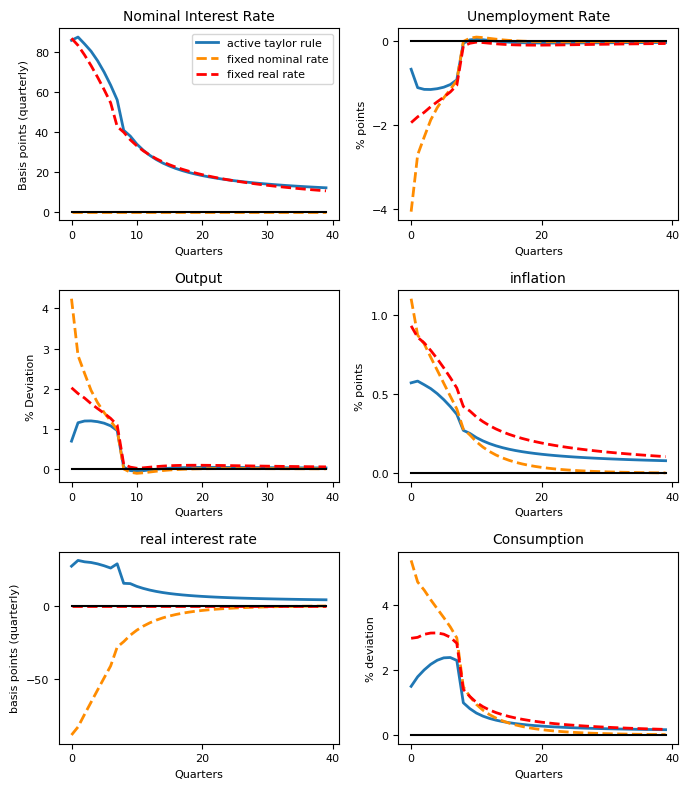

In [34]:

irfs_tau_fixed_real_rate = HANK_SAM_tax_cut_fixed_real_rate.solve_impulse_linear(SteadyState_Dict_tax_shock, unknowns_fixed_real_rate, targets_fixed_real_rate, shocks_tau)

plot_irfs_three_fixed_real_rate(irfs_tau,irfs_tau_fixed_nominal_rate,irfs_tau_fixed_real_rate,'active taylor rule' , 'fixed nominal rate', 'fixed real rate')




In [35]:
print('multiplier out of tax cut', NPV(irfs_tau['Y'], bigT)/NPV(irfs_tau['tax_cost'],bigT))
print('multiplier out of tax cut (fixed real rate)', NPV(irfs_tau_fixed_real_rate['Y'], bigT)/NPV(irfs_tau_fixed_real_rate['tax_cost'],bigT))

print('multiplier out of tax cut (fixed nominal rate)', NPV(irfs_tau_fixed_nominal_rate['Y'], bigT)/NPV(irfs_tau_fixed_nominal_rate['tax_cost'],bigT))


multiplier out of tax cut -0.7473725155038714
multiplier out of tax cut (fixed real rate) -1.172162150025349
multiplier out of tax cut (fixed nominal rate) -1.238809227382122


# Increase in UI replacement rate

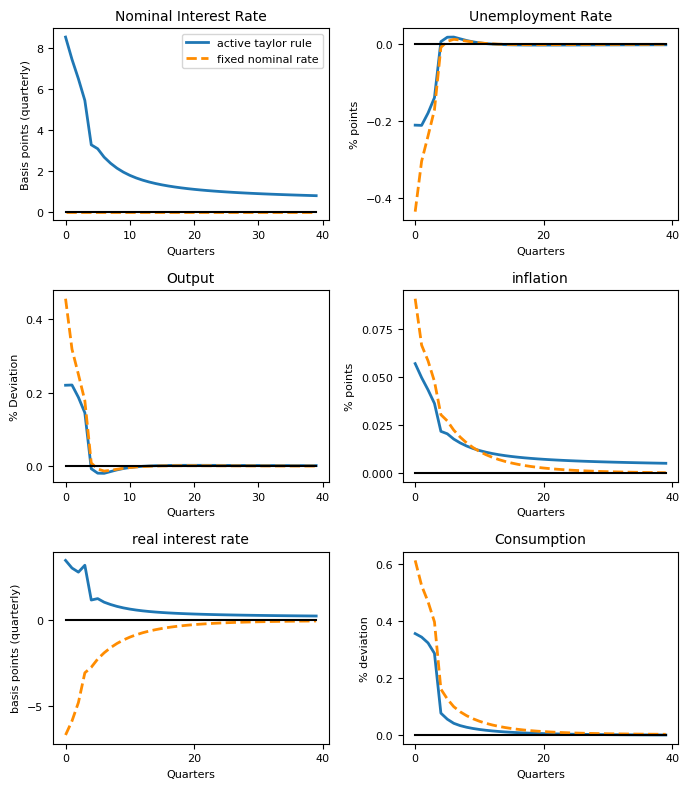

In [36]:
dUI_rr = np.zeros(bigT)
dUI_rr[:4] = .1
shocks_UI_rr = {'UI_rr': dUI_rr}


SteadyState_Dict_UI_rr = deepcopy(SteadyState_Dict)

SteadyState_Dict_UI_rr['phi_b'] = 0.015
SteadyState_Dict_UI_rr['phi_w'] = 0.837
SteadyState_Dict_UI_rr['rho_r'] = 0.0
SteadyState_Dict_UI_rr['phi_y'] = 0.0
SteadyState_Dict_UI_rr['phi_pi'] = 1.5
SteadyState_Dict_UI_rr['deficit_T'] = -1

SteadyState_Dict_UI_rr_fixed_nominal_rate = deepcopy(SteadyState_Dict_UI_rr)
SteadyState_Dict_UI_rr_fixed_nominal_rate['phi_pi'] = 0.0

irfs_UI_rr= HANK_SAM.solve_impulse_linear(SteadyState_Dict_UI_rr, unknowns, targets, shocks_UI_rr)
irfs_UI_rr_fixed_nominal_rate = HANK_SAM.solve_impulse_linear(SteadyState_Dict_UI_rr_fixed_nominal_rate, unknowns, targets, shocks_UI_rr)


irfs_UI_rr_fixed_real_rate = HANK_SAM_fixed_real_rate.solve_impulse_linear(SteadyState_Dict_UI_rr, unknowns_fixed_real_rate, targets_fixed_real_rate, shocks_UI_rr)  # solve for IRFs


green = 'green'

plot_irfs(irfs_UI_rr,irfs_UI_rr_fixed_nominal_rate,'active taylor rule' , 'fixed nominal rate')


# multipliers across the horizon

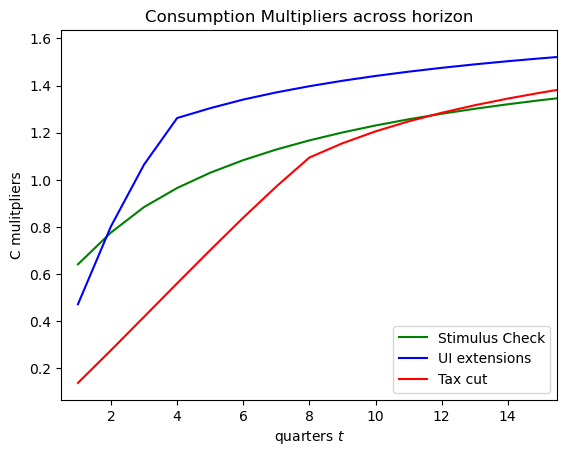

In [37]:
horizon_length = 20

multipliers_transfers = np.zeros(horizon_length)
multipliers_UI_extensions = np.zeros(horizon_length)
multipliers_UI_extensions_no_anticipation = np.zeros(horizon_length)
multipliers_tax_cut = np.zeros(horizon_length)
multipliers_UI_rr = np.zeros(horizon_length)

for i in range(horizon_length):


    multipliers_transfers[i] =  NPV(irfs_transfer_fixed_real_rate['C'], i + 1)/NPV(irfs_transfer_fixed_real_rate['transfers'],300)
    multipliers_UI_extensions[i] =  NPV(irfs_UI_extension_fixed_real_rate['C'], i + 1)/NPV(irfs_UI_extension_fixed_real_rate['UI_extension_cost'],300)
    multipliers_UI_extensions_no_anticipation[i] =  NPV(irf_UI_extend_realizations['C'], i + 1)/NPV(irf_UI_extend_realizations['UI_extension_cost'],300)

    multipliers_tax_cut[i] =  -NPV(irfs_tau_fixed_real_rate['C'], i + 1)/NPV(irfs_tau_fixed_real_rate['tax_cost'],300)
    multipliers_UI_rr[i] =  NPV(irfs_UI_rr_fixed_real_rate['C'], i + 1)/NPV(irfs_UI_rr_fixed_real_rate['UI_rr_cost'],300)



plt.plot(np.arange(horizon_length) +1,multipliers_transfers , label = 'Stimulus Check', color = 'green')
plt.plot(np.arange(horizon_length) +1,multipliers_UI_extensions , label = 'UI extensions' , color = 'blue')
plt.plot(np.arange(horizon_length) +1,multipliers_tax_cut , label = 'Tax cut', color = 'red')
#plt.plot(np.arange(horizon_length) +1,multipliers_UI_rr , label = 'Increase in UI replacement rate', color = 'darkorange')

#plt.plot(np.arange(horizon_length) +1,multipliers_UI_extensions_no_anticipation , label = 'UI extensions (households never learn of UI extensions)')
#plt.plot(np.arange(15) +1,multipliers_tax_cut , label = 'tax cut')

plt.legend(loc = 'lower right')
plt.ylabel('C mulitpliers')
plt.xlabel('quarters $t$')
plt.xlim(.5,15.5)
plt.title('Consumption Multipliers across horizon')
plt.savefig("figures/HANK_multipliers_w_splurge.pdf")
plt.savefig("figures/HANK_multipliers_w_splurge.svg")
plt.savefig("figures/HANK_multipliers_w_splurge.jpg")
plt.savefig("figures/HANK_multipliers_w_splurge.png")
plt.show()


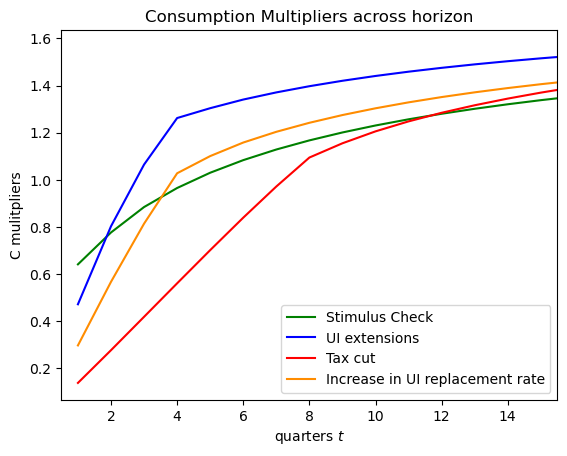

In [38]:
plt.plot(np.arange(horizon_length) +1,multipliers_transfers , label = 'Stimulus Check', color = 'green')
plt.plot(np.arange(horizon_length) +1,multipliers_UI_extensions , label = 'UI extensions' , color = 'blue')
plt.plot(np.arange(horizon_length) +1,multipliers_tax_cut , label = 'Tax cut', color = 'red')
plt.plot(np.arange(horizon_length) +1,multipliers_UI_rr , label = 'Increase in UI replacement rate', color = 'darkorange')

#plt.plot(np.arange(horizon_length) +1,multipliers_UI_extensions_no_anticipation , label = 'UI extensions (households never learn of UI extensions)')
#plt.plot(np.arange(15) +1,multipliers_tax_cut , label = 'tax cut')

plt.legend(loc = 'lower right')
plt.ylabel('C mulitpliers')
plt.xlabel('quarters $t$')
plt.xlim(.5,15.5)
plt.title('Consumption Multipliers across horizon')
plt.show()

## Pickle multipliers and save as CSV

In [39]:

Obj = {'transfers' :multipliers_transfers ,  'UI_extensions': multipliers_UI_extensions , 'tax_cut': multipliers_tax_cut  }
                
fileObj = open('multipliers_across_horizon_w_splurge.obj', 'wb')
pickle.dump(Obj,fileObj)
fileObj.close()         


In [40]:
# save as csv (easier to do with pandas)
import pandas as pd
df = pd.DataFrame(Obj)
df.to_csv("multipliers_across_horizon_w_splurge.csv", index=False)

In [41]:


#np.savetxt('multipliers_across_horizon.csv', multipliers_all, delimiter=',')


In [42]:
# from IPython.display import Image
# Image(filename='HA-fiscal.png', width=600, height=600)


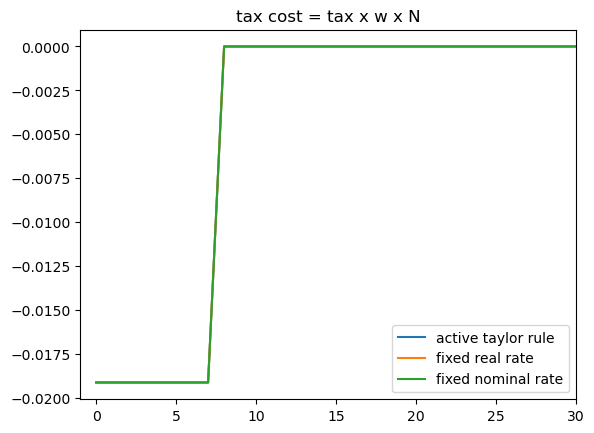

In [43]:
plt.plot(irfs_tau['tax_cost'] , label = 'active taylor rule')
plt.plot(irfs_tau_fixed_real_rate['tax_cost'], label = 'fixed real rate')
plt.plot(irfs_tau_fixed_nominal_rate['tax_cost'] , label = 'fixed nominal rate')
plt.legend()
plt.xlim(-1,30)
plt.title('tax cost = tax x w x N')
plt.show()

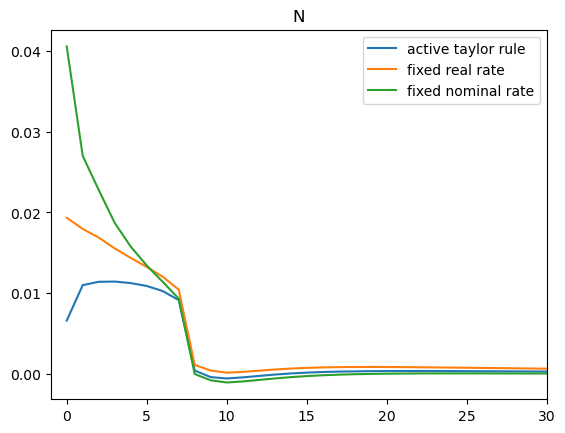

In [44]:
plt.plot(irfs_tau['N'] , label = 'active taylor rule')
plt.plot(irfs_tau_fixed_real_rate['N'], label = 'fixed real rate')
plt.plot(irfs_tau_fixed_nominal_rate['N'] , label = 'fixed nominal rate')
plt.legend()
plt.xlim(-1,30)
plt.title('N')
plt.show()

# Multipliers across horizon fixed nominal rate

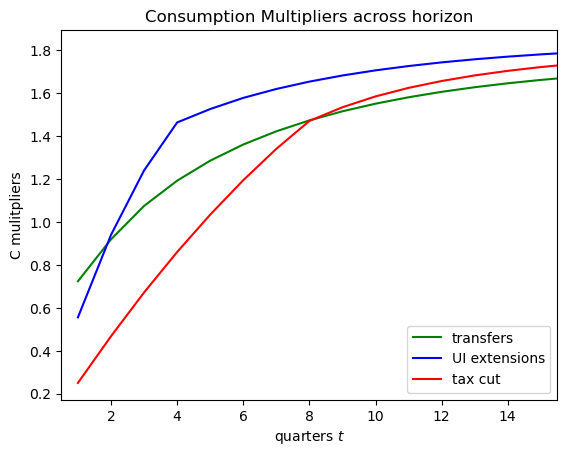

In [113]:
horizon_length = 20

multipliers_transfers_fixed_nominal_rate = np.zeros(horizon_length)
multipliers_UI_extensions_fixed_nominal_rate = np.zeros(horizon_length)
multipliers_UI_extensions_no_anticipation = np.zeros(horizon_length)
multipliers_tax_cut_fixed_nominal_rate = np.zeros(horizon_length)

multipliers_transfers = np.zeros(horizon_length)
multipliers_UI_extend = np.zeros(horizon_length)
multipliers_tax_cut = np.zeros(horizon_length)

multipliers_transfers_fixed_real_rate = np.zeros(horizon_length)
multipliers_UI_extensions_fixed_real_rate = np.zeros(horizon_length)
multipliers_tax_cut_fixed_real_rate = np.zeros(horizon_length)

for i in range(horizon_length):


    multipliers_transfers_fixed_nominal_rate[i] =  NPV(irfs_transfer_fixed_nominal_rate['C'], i + 1)/NPV(irfs_transfer_fixed_nominal_rate['transfers'],300)
    multipliers_UI_extensions_fixed_nominal_rate[i] =  NPV(irfs_UI_extend_fixed_nominal_rate['C'], i + 1)/NPV(irfs_UI_extend_fixed_nominal_rate['UI_extension_cost'],300)
    #multipliers_UI_extensions_no_anticipation[i] =  NPV(irf_UI_extend_realizations['C'], i + 1)/NPV(irf_UI_extend_realizations['UI_extension_cost'],300)
    multipliers_tax_cut_fixed_nominal_rate[i] =  -NPV(irfs_tau_fixed_nominal_rate['C'], i + 1)/NPV(irfs_tau_fixed_nominal_rate['tax_cost'],300)

    multipliers_transfers[i] =  NPV(irfs_transfer['C'], i + 1)/NPV(irfs_transfer['transfers'],300)
    multipliers_UI_extend[i] =  NPV(irfs_UI_extend['C'], i + 1)/NPV(irfs_UI_extend['UI_extension_cost'],300)
    multipliers_tax_cut[i] =  -NPV(irfs_tau['C'], i + 1)/NPV(irfs_tau['tax_cost'],300)

    multipliers_transfers_fixed_real_rate[i] =  NPV(irfs_transfer_fixed_real_rate['C'], i + 1)/NPV(irfs_transfer_fixed_real_rate['transfers'],300)
    multipliers_UI_extensions_fixed_real_rate[i] =  NPV(irfs_UI_extension_fixed_real_rate['C'], i + 1)/NPV(irfs_UI_extension_fixed_real_rate['UI_extension_cost'],300)
    multipliers_tax_cut_fixed_real_rate[i] =  -NPV(irfs_tau_fixed_real_rate['C'], i + 1)/NPV(irfs_tau_fixed_real_rate['tax_cost'],300)




plt.plot(np.arange(horizon_length) +1,multipliers_transfers_fixed_nominal_rate , label = 'transfers', color = 'green')
plt.plot(np.arange(horizon_length) +1,multipliers_UI_extensions_fixed_nominal_rate , label = 'UI extensions' , color = 'blue')
plt.plot(np.arange(horizon_length) +1,multipliers_tax_cut_fixed_nominal_rate , label = 'tax cut', color = 'red')

#plt.plot(np.arange(horizon_length) +1,multipliers_UI_extensions_no_anticipation , label = 'UI extensions (households never learn of UI extensions)')
#plt.plot(np.arange(15) +1,multipliers_tax_cut , label = 'tax cut')

plt.legend(loc = 'lower right')
plt.ylabel('C mulitpliers')
plt.xlabel('quarters $t$')
plt.xlim(.5,15.5)
plt.title('Consumption Multipliers across horizon')
plt.show()

In [46]:
# from IPython.display import Image
# Image(filename='HA-fiscal.png', width=600, height=600)


In [76]:
def plot_consumption_irfs_three_experiments(irf_UI1,irf_UI2,irf_UI3, irf_SC1,irf_SC2,irf_SC3, irf_TC1,irf_TC2,irf_TC3):
    
    green = 'darkorange'
    red = 'red'

    Length = 12
    fontsize = 10
    width = 2
    label_size = 8
    legend_size = 8
    ticksize = 8
    fig, axs = plt.subplots(1, 3, figsize=(10,3))

    y_max1 =  max(100*irf_TC2['C'][:Length]/C_ss)*1.05
    y_max2 =  max(100*irf_SC2['C'][:Length]/C_ss)*1.05
    y_max = max([y_max1,y_max2])
    for i in range(3):
        axs[i].set_ylim(0, y_max)

    axs[1].plot(100*irf_UI1['C'][:Length]/C_ss,linewidth= width, label = "Active Taylor Rule")
    axs[1].plot(100*irf_UI2['C'][:Length]/C_ss,linewidth= width, label = "Fixed Nominal Rate", linestyle = '--', color = green)
    axs[1].plot(100*irf_UI3['C'][:Length]/C_ss,linewidth= width, label = "Fixed Real " , linestyle = '--', color = red)
    axs[1].set_title("UI Extension",fontdict={'fontsize': fontsize})


    axs[0].plot(100*irf_SC1['C'][:Length]/C_ss,linewidth= width, label = "Active Taylor Rule")
    axs[0].plot(100*irf_SC2['C'][:Length]/C_ss,linewidth= width, label = "Fixed Nominal Rate", linestyle = '--', color = green)
    axs[0].plot(100*irf_SC3['C'][:Length]/C_ss,linewidth= width, label = "Fixed Real " , linestyle = '--', color = red)
    axs[0].set_title("Stimulus Check",fontdict={'fontsize': fontsize})
    axs[0].legend(prop={'size': legend_size})

    axs[2].plot(100*irf_TC1['C'][:Length]/C_ss,linewidth= width, label = "Active Taylor Rule")
    axs[2].plot(100*irf_TC2['C'][:Length]/C_ss,linewidth= width, label = "Fixed Nominal Rate", linestyle = '--', color = green)
    axs[2].plot(100*irf_TC3['C'][:Length]/C_ss,linewidth= width, label = "Fixed Real " , linestyle = '--', color = red)
    axs[2].set_title("Tax Cut",fontdict={'fontsize': fontsize})

    for i in range(3):
        axs[i].plot(np.zeros(Length),'k' )
        axs[i].tick_params(axis='both', labelsize=ticksize)

        axs[i].set_ylabel('% consumption deviation', fontsize = label_size)
        axs[i].set_xlabel('Quarters', fontsize = label_size)
        axs[i].locator_params(axis='both', nbins=4) 

    fig.tight_layout()

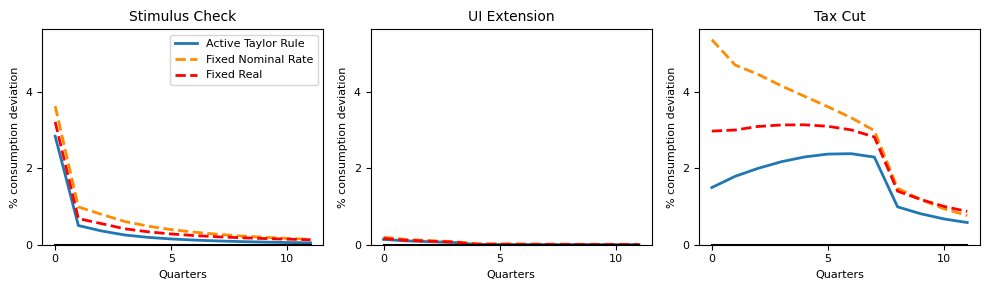

In [77]:

plot_consumption_irfs_three_experiments(irfs_UI_extend,irfs_UI_extend_fixed_nominal_rate,irfs_UI_extension_fixed_real_rate, irfs_transfer,irfs_transfer_fixed_nominal_rate,irfs_transfer_fixed_real_rate, irfs_tau,irfs_tau_fixed_nominal_rate,irfs_tau_fixed_real_rate)
plt.savefig("figures/HANK_IRFs_w_splurge.pdf")



In [101]:
# Make each plot individually to match what Ivan does in the main code
def plot_consumption_irf(irf1, irf2, irf3, y_max, filename, legend = False):
    green = 'darkorange'
    red = 'red'

    Length = 12
    plt.figure(figsize=(4, 4))
    x_axis = np.arange(1,Length+1)

    plt.plot(x_axis,100*irf1['C'][:Length]/C_ss, label="Active Taylor Rule")
    plt.plot(x_axis,100*irf2['C'][:Length]/C_ss, label="Fixed Nominal Rate", linestyle='--', color=green)
    plt.plot(x_axis,100*irf3['C'][:Length]/C_ss, label="Fixed Real", linestyle='--', color=red)

    plt.xticks(np.arange(min(x_axis), max(x_axis)+1, 1.0))
    plt.xlabel('quarter')
    #plt.ylabel('% difference relative to recession')
    #plt.savefig(fig_dir +'recession_taxcut_relrecession.pdf')
    plt.ylim(0, y_max)
    if legend:
        plt.legend(loc='best')
        plt.ylabel('% consumption deviation')
    make_figs(filename, True , False, target_dir=fig_dir)
    plt.show() 

Saving figure HANK_transfer_IRF in figures/


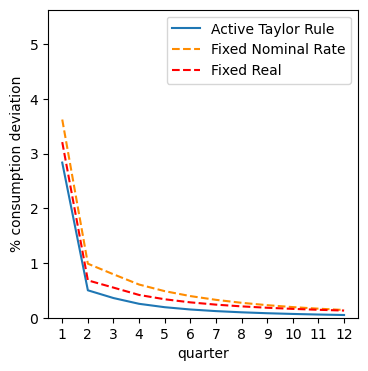

Saving figure HANK_UI_IRF in figures/


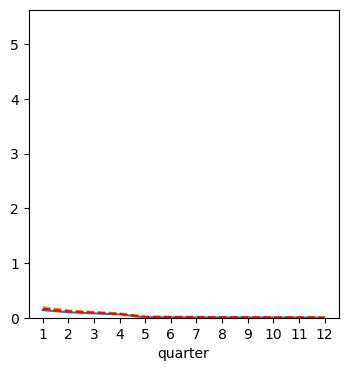

Saving figure HANK_tax_IRF in figures/


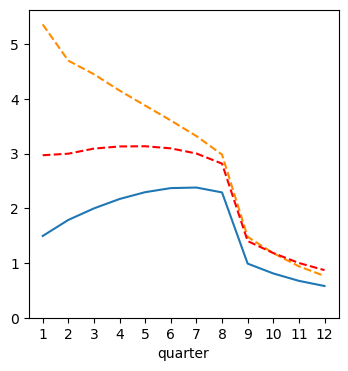

In [102]:
fig_dir = "figures/"
y_max =  max(100*irfs_tau_fixed_nominal_rate['C'][:12]/C_ss)*1.05
plot_consumption_irf( irfs_transfer,irfs_transfer_fixed_nominal_rate,irfs_transfer_fixed_real_rate, y_max, "HANK_transfer_IRF", legend=True)
plot_consumption_irf( irfs_UI_extend,irfs_UI_extend_fixed_nominal_rate,irfs_UI_extension_fixed_real_rate, y_max, "HANK_UI_IRF")
plot_consumption_irf( irfs_tau,irfs_tau_fixed_nominal_rate,irfs_tau_fixed_real_rate, y_max, "HANK_tax_IRF")

In [110]:
# Make each plot individually to match what Ivan does in the main code
def plot_consumption_multipliers(multiplier1, multiplier2, multiplier3, y_max, filename, legend = False):
    green = 'darkorange'
    red = 'red'

    Length = 12
    plt.figure(figsize=(4, 4))
    x_axis = np.arange(1,Length+1)

    plt.plot(x_axis,multiplier1[0:Length], label="Active Taylor Rule")
    plt.plot(x_axis,multiplier2[0:Length], label="Fixed Nominal Rate", linestyle='--', color=green)
    plt.plot(x_axis,multiplier3[0:Length], label="Fixed Real", linestyle='--', color=red)

    plt.xticks(np.arange(min(x_axis), max(x_axis)+1, 1.0))
    plt.xlabel('quarter')
    plt.ylim(0, y_max)
    if legend:
        plt.legend(loc='best')
    make_figs(filename, True , False, target_dir=fig_dir)
    plt.show() 

Saving figure HANK_transfer_multiplier in figures/


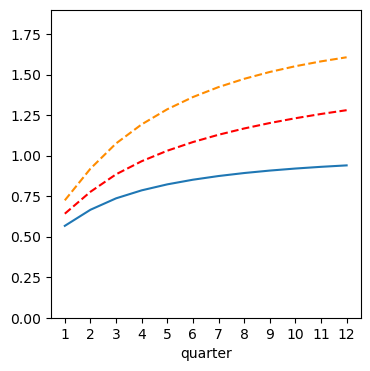

Saving figure HANK_UI_multiplier in figures/


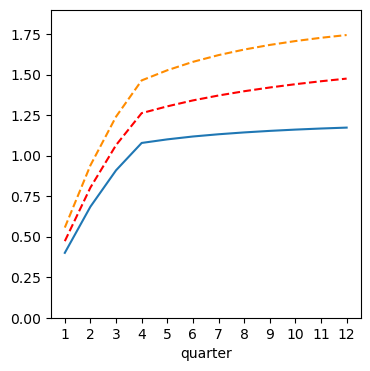

Saving figure HANK_tax_multiplier in figures/


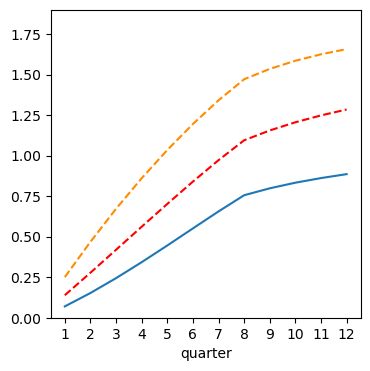

In [114]:
fig_dir = "figures/"
y_max =  1.9
plot_consumption_multipliers( multipliers_transfers,multipliers_transfers_fixed_nominal_rate,multipliers_transfers_fixed_real_rate, y_max, "HANK_transfer_multiplier")
plot_consumption_multipliers( multipliers_UI_extend,multipliers_UI_extensions_fixed_nominal_rate,multipliers_UI_extensions_fixed_real_rate, y_max, "HANK_UI_multiplier")
plot_consumption_multipliers( multipliers_tax_cut,multipliers_tax_cut_fixed_nominal_rate,multipliers_tax_cut_fixed_real_rate, y_max, "HANK_tax_multiplier")

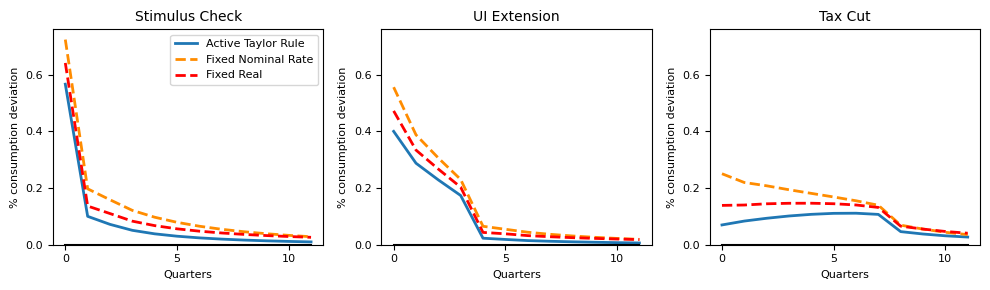

In [78]:
# Now plot the same normalized by spending
plot_consumption_irfs_three_experiments(irfs_UI_extend/NPV(irfs_UI_extend['UI_extension_cost']/C_ss,300)/100, \
                                        irfs_UI_extend_fixed_nominal_rate/NPV(irfs_UI_extend_fixed_nominal_rate['UI_extension_cost']/C_ss,300)/100, \
                                        irfs_UI_extension_fixed_real_rate/NPV(irfs_UI_extension_fixed_real_rate['UI_extension_cost']/C_ss,300)/100, \
                                        irfs_transfer/NPV(irfs_transfer['transfers']/C_ss,300)/100, \
                                        irfs_transfer_fixed_nominal_rate/NPV(irfs_transfer_fixed_nominal_rate['transfers']/C_ss,300)/100,\
                                        irfs_transfer_fixed_real_rate/NPV(irfs_transfer_fixed_real_rate['transfers']/C_ss,300)/100, \
                                        -irfs_tau/NPV(irfs_tau['tax_cost']/C_ss,300)/100, \
                                        -irfs_tau_fixed_nominal_rate/NPV(irfs_tau_fixed_nominal_rate['tax_cost']/C_ss,300)/100, \
                                        -irfs_tau_fixed_real_rate/NPV(irfs_tau_fixed_real_rate['tax_cost']/C_ss,300)/100)


In [79]:

latex_code = [
        "\\begin{table}[htbp]",
        "\\centering",
        "\\caption{Fiscal Multipliers}",
        "\\begin{tabular}{l|ccc}",
        "\\hline",
        " & UI Extension & Stimulus Check & Tax Cut \\\\",
        "\\hline",
        f"Active Taylor Rule & {NPV(irfs_UI_extend['Y'], bigT)/NPV(irfs_UI_extend['UI_extension_cost'],bigT):.2f} & {NPV(irfs_transfer['Y'], bigT)/NPV(irfs_transfer['transfers'],bigT):.2f} & {NPV(irfs_tau['Y'], bigT)/NPV(irfs_tau['tax_cost'],bigT):.2f} \\\\",
        f"Fixed Nominal Rate & {NPV(irfs_UI_extend_fixed_nominal_rate['Y'], bigT)/NPV(irfs_UI_extend_fixed_nominal_rate['UI_extension_cost'],bigT):.2f} & {NPV(irfs_transfer_fixed_nominal_rate['Y'], bigT)/NPV(irfs_transfer_fixed_nominal_rate['transfers'],bigT):.2f} & {NPV(irfs_tau_fixed_nominal_rate['Y'], bigT)/NPV(irfs_tau_fixed_nominal_rate['tax_cost'],bigT):.2f} \\\\",
        f"Fixed Real Rate & {NPV(irfs_UI_extension_fixed_real_rate['Y'], bigT)/NPV(irfs_UI_extension_fixed_real_rate['UI_extension_cost'],bigT):.2f} & { NPV(irfs_transfer_fixed_real_rate['Y'], bigT)/NPV(irfs_transfer_fixed_real_rate['transfers'],bigT):.2f} & {NPV(irfs_tau_fixed_real_rate['Y'], bigT)/NPV(irfs_tau_fixed_real_rate['tax_cost'],bigT):.2f} \\\\",
        "\\hline",
        "\\end{tabular}",
        "\\end{table}"
    ]
print('\n'.join(latex_code))

\begin{table}[htbp]
\centering
\caption{Fiscal Multipliers}
\begin{tabular}{l|ccc}
\hline
 & UI Extension & Stimulus Check & Tax Cut \\
\hline
Active Taylor Rule & 0.92 & 0.80 & -0.75 \\
Fixed Nominal Rate & 1.27 & 1.22 & -1.24 \\
Fixed Real Rate & 1.23 & 1.17 & -1.17 \\
\hline
\end{tabular}
\end{table}
